# Analysis of Output
After running a trial, I move all output to its own directory, e.g. `build/src/trial_smallB_n064`.

The description of B is as follows:

| Size | Value |
| :-   | :-:   |
| small| .1    |
|med   | 1     |
|big   | 10    |

The number after `n` (064 above) is the number of grid cells per axis.

In [29]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import viscid
viscid.calculator.evaluator.enabled = True
from viscid.plot import vpyplot as vlt

import os
import ipywidgets as widgets
from IPython.display import display

%config InlineBackend.figure_format = 'retina'

In [74]:
# where the data is
trialpath="/Users/james/Code/cpp/PSC/psc/build/src"

# which data to use
trialfile = ""

all_files = os.listdir(trialpath)
valid_trialfiles = [file for file in all_files if "trial_" in file]
if "pfd.xdmf" in all_files:
    valid_trialfiles = ["."] + valid_trialfiles

w = widgets.Dropdown(
    options=valid_trialfiles,
    value=valid_trialfiles[0],
    description='Trial file:',
    disabled=False,
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global trialfile
        trialfile = change['new']

w.observe(on_change)

display(w)

Dropdown(description='Trial file:', options=('trial_medB_n064', 'trial_smallB_n064'), value='trial_medB_n064')

## Fields and Current
`hx_fc` at time=1 is generally pretty cool

In [62]:
run = f"{trialpath}/{trialfile}/pfd.xdmf"
vf = viscid.load_file(run, force_reload=True)
print([f.name for f in vf.iter_fields()])

['jx_ec', 'jy_ec', 'jz_ec', 'ex_ec', 'ey_ec', 'ez_ec', 'hx_fc', 'hy_fc', 'hz_fc']


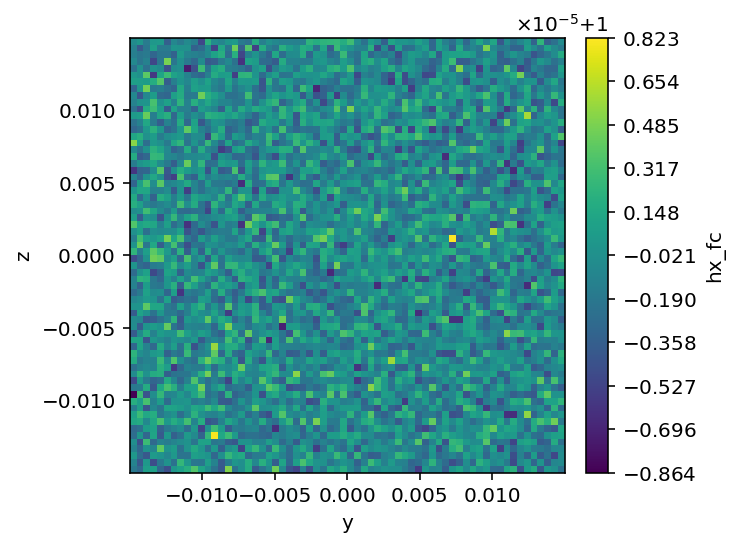

In [65]:
vf.activate_time(20)
vlt.plot(vf["hx_fc"]);

## Moments

In [71]:
run_moments = f"{trialpath}/{trialfile}/pfd_moments.xdmf"
vf_moments = viscid.load_file(run_moments, force_reload=True)
print([f.name for f in vf_moments.iter_fields()])

['rho_e', 'jx_e', 'jy_e', 'jz_e', 'px_e', 'py_e', 'pz_e', 'txx_e', 'tyy_e', 'tzz_e', 'txy_e', 'tyz_e', 'tzx_e', 'rho_i', 'jx_i', 'jy_i', 'jz_i', 'px_i', 'py_i', 'pz_i', 'txx_i', 'tyy_i', 'tzz_i', 'txy_i', 'tyz_i', 'tzx_i']


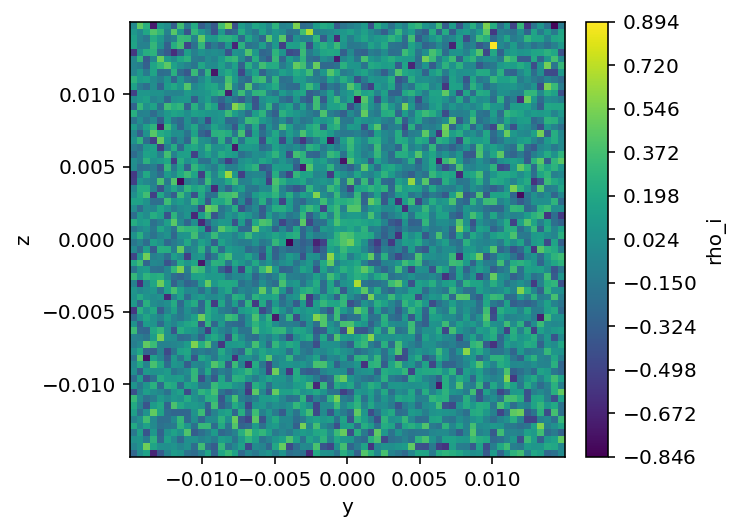

In [72]:
vf_moments.activate_time(25)
vlt.plot(vf_moments["rho_i"] + vf_moments["rho_e"]);

## Discrepancy in E

In [69]:
run_gauss = f"{trialpath}/{trialfile}/gauss.xdmf"
vf_gauss = viscid.load_file(run_gauss, force_reload=True)
print([f.name for f in vf_gauss.iter_fields()])

['rho', 'dive']


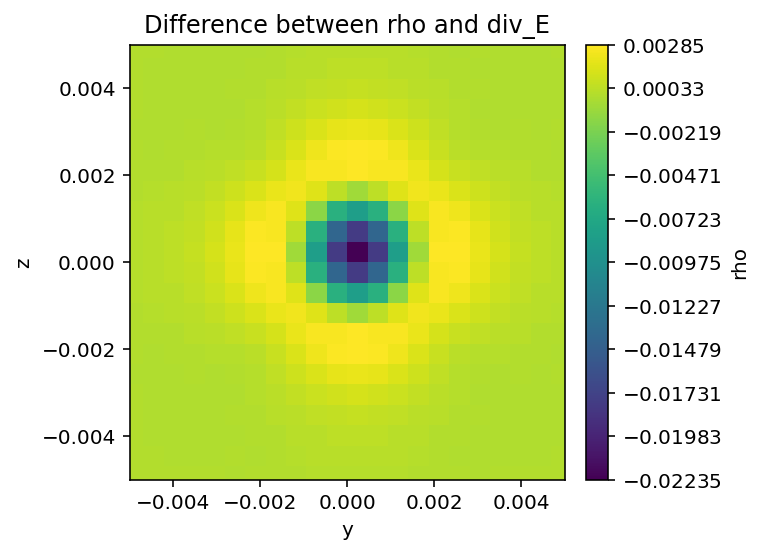

In [70]:
vf_gauss.activate_time(0)
zoom = .005
vlt.plot(vf_gauss["rho"] - vf_gauss["dive"]);
plt.title("Difference between rho and div_E")
plt.xlim(-zoom, zoom)
plt.ylim(-zoom, zoom);